## Diffusion lengthscale

Toy model of 1-D diffusion of a linear concentration profile through two layers with different diffusivities. 

We discretize the 1-D diffusion equation 

$$\frac{\partial C}{\partial t} =  \frac{\partial}{\partial z}\Big(\frac{\kappa\partial C}{\partial z}\Big)$$

using using forward differences for time and the spatial stencil

 o----x----o----x----o    

i-1---ki---i---ki+1--i+1   

Ci-1-------Ci--------Ci+1   


as

$$\frac{C_i^{n+1}-C_i^{n}}{\Delta t}= \frac{\kappa_i(C_{i}^n-C_{i-1}^n)-\kappa_{i+1}(C_{i+1}^n-C_i^n)}{\Delta z^2}$$

using forward differences for time. Note that when $\kappa_i = \kappa_{i+1}$, we recover the usual central differences scheme for the second derivative:

$$\frac{C_i^{n+1}-C_i^{n}}{\Delta t}= \frac{\kappa(C_{i+1}^n-2C_{i}^n+C_{i-1}^n)}{\Delta z^2}$$

So, we calculate the concentration at time step n+1 as

$$C_i^{n+1}=\frac{\Delta t}{\Delta z^2}(\kappa_i(C_{i}^n-C_{i-1}^n)-\kappa_{i+1}(C_{i+1}^n-C_i^n)) + C_i^{n}$$.


In [1]:
import cmocean as cmo
import numpy as np  
import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib.patches as mpatches

%matplotlib inline

/home/kramosmu/anaconda3/lib/python3.5/site-packages/cmocean/tools.py:76: MatplotlibDeprecationWarning: The is_string_like function was deprecated in version 2.1.
  if not mpl.cbook.is_string_like(rgbin[0]):


In [2]:
# Plots appearance
sns.set_context('talk')
sns.set_style('whitegrid')

In [3]:
def timestepping(IC, kappa, dt, dz, nt):
    '''Iterate for nt timesteps the solution to the diffusion equation
    INPUT
    IC: vector with the initial condition (1D numpy array)
    kappa: 1D numpy array, same size as u
    dt: timestep size (scalar)
    dz: depth of cells (scalar)
    nt: number of timesteps
    
    OUTPUT
    u: 1d numpy array with concentrations after nt timesteps.
    '''
    un = np.ones(nz) #our placeholder array, un, to advance the solution in time
    u = np.ones(nz) #our placeholder array, un, to advance the solution in time
    u = IC.copy()
    
    for n in range(nt):  #iterate through time
        un = u.copy() ##copy the existing values of u into un
        for i in range(1, nz - 1):
            u[i] = un[i] + (kappa[i] * dt / dz**2 * (un[i+1] - 2 * un[i] + un[i-1]))
    return u

def timesteppingKv(IC, kappa, dt, dz, nt):
    '''Iterate for nt timesteps the solution to the diffusion equation with variable Kv
    INPUT
    IC: vector with the initial condition (1D numpy array)
    kappa: 1D numpy array, same size as u
    dt: timestep size (scalar)
    dz: depth of cells (scalar)
    nt: number of timesteps
    
    OUTPUT
    u: 1d numpy array with concentrations after nt timesteps.
    '''
    un = np.ones(nz) 
    u = np.ones(nz) 
    u = IC.copy()
    
    for n in range(nt):  #iterate through time
        un = u.copy() ##copy the existing values of u into un
        for i in range(1, nz - 1):
            u[i] = un[i] + dt * (kappa[i]*(un[i-1]-un[i])/dz**2 - kappa[i+1]*(un[i]-un[i+1])/dz**2)
    return u

def smoothHS(nx, xi, epsilon, dx, k1, k2):
    '''Build smooth Heaviside function, of width 2*epsilon centred at index xi
    Check:
    xi < nx ''' 
    
    hs = np.zeros(nx)
    
    hs[:xi-epsilon+1] = k1
    
    for ii in range(2*epsilon):
        hs[xi+ii-epsilon] = k1+(0.5 + (ii-epsilon)/(2*epsilon) + 
                             (np.sin(np.pi*(ii-epsilon)/epsilon))/(2*np.pi))*k2
    
    hs[xi+epsilon-1:] = k2+k1
    
    return hs
     
    
def plotICs(IniC,kappa,L,nz):
    '''Plots initial conditions and diffusivity profile, creates figure inside and returns fig and ax handles'''
    fig,(ax1,ax2) = plt.subplots(1,2,sharey = True,figsize=(8,3))

    ax1.plot(IniC, -np.linspace(0, L, nz))
    ax1.set_xlabel('Concentration ($\mu M$)')
    ax1.set_ylabel('Depth (m)')
    ax1.set_title('Initial concentration')

    ax2.plot(kappa,-np.linspace(0, L, nz))
    ax2.set_xlabel('$\kappa$ (m$^2$s$^{-1}$)')
    ax2.set_title('Diffusivity profile')
    
    return(fig,ax1,ax2)

def plotCpaper(ax, C, L, nz, colour):
    '''Plots concentration over an existing ax and returns ax handle and line handle'''
    line, = ax.plot(C, -np.linspace(0, L, nz), color=colour);
    ax.set_xlabel('Concentration ($\mu M$)', labelpad=0.5)
    ax.set_ylabel('Depth (m)',labelpad=-0.5)
    return (line)

def plotC(ax, C, L, nz):
    '''Plots concentration over an existing ax and returns ax handle and line handle'''
    line, = ax.plot(C, -np.linspace(0, L, nz));
    ax.set_xlabel('Concentration ($\mu M$)', labelpad=0.5)
    ax.set_ylabel('Depth (m)',labelpad=-0.5)
    return (line)

def plotdCdz(ax, C, L, nz):
    '''Plots vertical concentration gradient over an existing ax and returns ax handle and line handle'''
    z = -np.linspace(0, L, nz)
    dCdz = (C[:-1]-C[1:])/(z[:-1]-z[1:])
    line, = ax.plot(dCdz, z[:-1]);
    ax.set_xlabel('$\partial_zC$ ($\mu M m^{-1}$)', labelpad=0.5)
    ax.set_ylabel('Depth (m)',labelpad=-0.5)
    return (line)

In [4]:
# INITIALIZATION 

# Space
nz = 100           # number of points in z
L = 100            # total depth (m)
dz = L / (nz - 1)  # vertical spacing (m)

# Time
dt = 60  # time step (s)
to_day = dt/(3600*24)

# Diffusivity
kappa_bg = 1E-5              # background diffusivity
kappa_can = 1E-3             # canyon diffusivity
kappa = np.ones(nz)*kappa_bg # Diffuisivity profile
kappa[int(nz/2):] = kappa_can

#epsilon = 10
#kappa = smoothHS(nz, 50, epsilon, dz, kappa_bg, kappa_can)

# Talk to me
print('The time step is %1.1f seconds' %dt)
print('The vertical resolution is %1.3f meters' %dz)

The time step is 60.0 seconds
The vertical resolution is 1.010 meters


## Linear profile

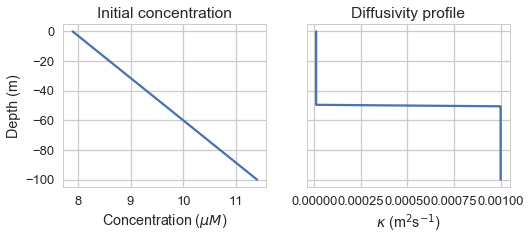

In [5]:
# Initial conditon
IC = np.ones(nz)
for ii in range(nz):
    IC[ii]=0.035*ii*dz+7.9
    
fig, ax1, ax2 = plotICs(IC,kappa,L,nz)

## Smoothed $\kappa$ profile

What happens if we smooth out the diffusivity profile from a step (Heaviside function) to a smoothed Heaviside function? (The concentration will look smoother but how does it change the tracer transport?)

Smoothed Heaviside function:

$HS(z) = \begin{cases}
\kappa_{bg} &\mbox{if } z<\frac{L}{2}-\epsilon \\
\kappa_{bg}+ \kappa_{can}(0.5 + \frac{z-\epsilon}{2\epsilon} + \frac{1}{2\pi}\sin{\frac{\pi(z-\epsilon)}{\epsilon}}) & \mbox{if } \frac{L}{2}-\epsilon < z < \frac{L}{2}+\epsilon \\
\kappa_{can} & \mbox{if }  \frac{L}{2}+\epsilon < z
 \end{cases} $

We will compare several values of $\epsilon$.

In [6]:
# Smoothed Heaviside function for diffusivity
e01 = 1
kappa_e01 = smoothHS(nz, int(nz/2), e01, dz, kappa_bg, kappa_can)

e05 = 5
kappa_e05 = smoothHS(nz, int(nz/2), e05, dz, kappa_bg, kappa_can)

e10 = 10
kappa_e10 = smoothHS(nz, int(nz/2), e10, dz, kappa_bg, kappa_can)

e25 = 25
kappa_e25 = smoothHS(nz, int(nz/2), e25, dz, kappa_bg, kappa_can)

e50 = 50
kappa_e50 = smoothHS(nz, int(nz/2), e50, dz, kappa_bg, kappa_can)

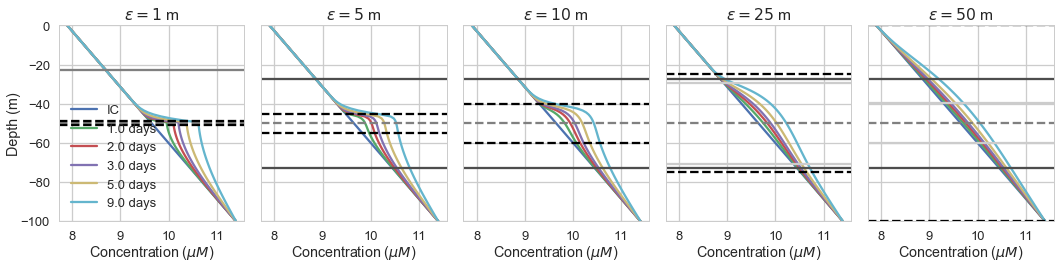

In [7]:
# PLOT RESULTING CONCENTRATION

fig, ax = plt.subplots(1,5, figsize=(15,4), sharey = True)

for axii in ax: 
    l1 = plotC(axii, IC, L, nz)
lines = [l1]

times = [1440,2880,4320,7200, 12960]

for time in times:
    conc01 = timesteppingKv(IC, kappa_e01, dt, dz, time)
    conc05 = timesteppingKv(IC, kappa_e05, dt, dz, time)
    conc10 = timesteppingKv(IC, kappa_e10, dt, dz, time)
    conc25 = timesteppingKv(IC, kappa_e25, dt, dz, time)
    conc50 = timesteppingKv(IC, kappa_e50, dt, dz, time)
    
    l2 = plotC(ax[0], conc01, L, nz)
    l3 = plotC(ax[1], conc05, L, nz)
    l4 = plotC(ax[2], conc10, L, nz)
    l5 = plotC(ax[3], conc25, L, nz)
    l6 = plotC(ax[4], conc50, L, nz)
    
    lines.append(l2)

ax[0].legend((lines), ('IC', '%1.1f days' %(times[0]*to_day),'%1.1f days' %(times[1]*to_day),
                     '%1.1f days' %(times[2]*to_day),'%1.1f days'%(times[3]*to_day),
                    '%1.1f days'%(times[4]*to_day)), loc=0) 

ax[0].set_title('$\epsilon = 1$ m')
ax[1].set_title('$\epsilon = 5$ m')
ax[2].set_title('$\epsilon = 10$ m')
ax[3].set_title('$\epsilon = 25$ m')
ax[4].set_title('$\epsilon = 50$ m')

for ii, eps in zip(range(1,5), [5,10,25,50]):
    ax[ii].set_ylabel('')
    ax[ii].axhline(-L/2, color='0.5',linestyle='--')
    ax[ii].axhline(-(L/2) + eps, color='k', linestyle='--')
    ax[ii].axhline(-(L/2) - eps,color='k',linestyle='--')
    ax[ii].axhline(-(L/2+(6*3600*24*(kappa_can-kappa_bg))**0.5), color='0.3')
    ax[ii].axhline(-(L/2-(6*3600*24*(kappa_can-kappa_bg))**0.5), color='0.3')
    
    ax[ii].axhline(-(L/2+(6*3600*24*(kappa_can-kappa_bg)/eps)), color='0.8')
    ax[ii].axhline(-(L/2-(6*3600*24*(kappa_can-kappa_bg)/eps)), color='0.8')
   
ax[0].axhline(-L/2, color='0.5',linestyle='--')
ax[0].axhline(-(L/2) + 1, color='k', linestyle='--')
ax[0].axhline(-(L/2) - 1,color='k',linestyle='--')
ax[0].axhline(-(6*3600*24*(kappa_can-kappa_bg))**0.5, color='0.5')
ax[0].axhline(-(6*3600*24*(kappa_can-kappa_bg)/1), color='0.3')
   
ax[0].set_ylim(-L,0)
plt.tight_layout()
#plt.savefig('Cprofiles_epsilon.eps',format='eps',bbox_inches='tight')


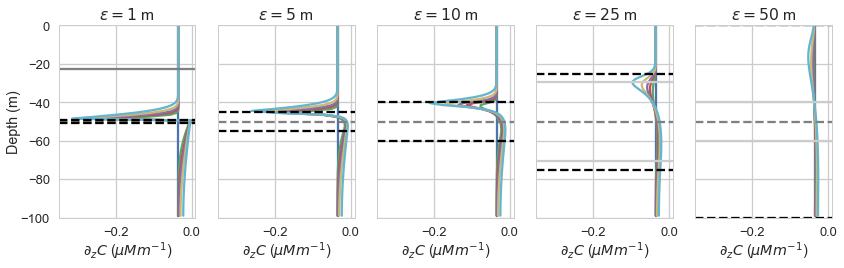

In [8]:
# PLOT RESULTING Derivative
fig, ax = plt.subplots(1,5, figsize=(12,4), sharey = True)

for axii in ax: 
    l1 = plotdCdz(axii, IC, L, nz)
lines = [l1]

times = [1440,2880,4320,7200, 12960]

for time in times:
    conc01 = timesteppingKv(IC, kappa_e01, dt, dz, time)
    conc05 = timesteppingKv(IC, kappa_e05, dt, dz, time)
    conc10 = timesteppingKv(IC, kappa_e10, dt, dz, time)
    conc25 = timesteppingKv(IC, kappa_e25, dt, dz, time)
    conc50 = timesteppingKv(IC, kappa_e50, dt, dz, time)
    
    l2 = plotdCdz(ax[0], conc01, L, nz)
    l3 = plotdCdz(ax[1], conc05, L, nz)
    l4 = plotdCdz(ax[2], conc10, L, nz)
    l5 = plotdCdz(ax[3], conc25, L, nz)
    l6 = plotdCdz(ax[4], conc50, L, nz)
    lines.append(l2)

    
#ax[3].legend((lines), ('IC', '%1.1f days' %(times[0]*to_day),'%1.1f days' %(times[1]*to_day),
#                     '%1.1f days' %(times[2]*to_day),'%1.1f days'%(times[3]*to_day),
#                    '%1.1f days'%(times[4]*to_day)), bbox_to_anchor=(1,1)) 

ax[0].set_title('$\epsilon = 1$ m')
ax[1].set_title('$\epsilon = 5$ m')
ax[2].set_title('$\epsilon = 10$ m')
ax[3].set_title('$\epsilon = 25$ m')
ax[4].set_title('$\epsilon = 50$ m')

ax[0].set_xlim(-0.35,0.01)
ax[1].set_xlim(-0.35,0.01)
ax[2].set_xlim(-0.35,0.01)
ax[3].set_xlim(-0.35,0.01)
ax[4].set_xlim(-0.35,0.01)

for ii, eps in zip(range(1,5), [5,10,25,50]):
    ax[ii].set_ylabel('')
    ax[ii].axhline(-L/2, color='0.5',linestyle='--')
    ax[ii].axhline(-(L/2) + eps, color='k', linestyle='--')
    ax[ii].axhline(-(L/2) - eps,color='k',linestyle='--')
   # ax[ii].axhline(-(L/2+(6*3600*24*(kappa_can-kappa_bg))**0.5), color='0.3')
   # ax[ii].axhline(-(L/2-(6*3600*24*(kappa_can-kappa_bg))**0.5), color='0.3')
    ax[ii].axhline(-(L/2+(6*3600*24*(kappa_can-kappa_bg)/eps)), color='0.8')
    ax[ii].axhline(-(L/2-(6*3600*24*(kappa_can-kappa_bg)/eps)), color='0.8')
   
ax[0].axhline(-L/2, color='0.5',linestyle='--')
ax[0].axhline(-(L/2) + 1, color='k', linestyle='--')
ax[0].axhline(-(L/2) - 1,color='k',linestyle='--')
ax[0].axhline(-(6*3600*24*(kappa_can-kappa_bg))**0.5, color='0.5')
ax[0].axhline(-(6*3600*24*(kappa_can-kappa_bg)/1), color='0.3')

ax[0].set_ylim(-L,0)

plt.tight_layout()

#plt.savefig('dCdzprofiles_Kvs.eps',format='eps',bbox_inches='tight')


### Total flux mismatch

In [9]:
K_e05 = smoothHS(nz, int(nz/2), 5, dz, kappa_bg, kappa_can)
K_e10 = smoothHS(nz, int(nz/2), 10, dz, kappa_bg, kappa_can)
K_e25 = smoothHS(nz, int(nz/2), 25, dz, kappa_bg, kappa_can)
K_e50 = smoothHS(nz, int(nz/2), 50, dz, kappa_bg, kappa_can)

0.035
0.00035
0.00035
0.00035
0.00035
0.00035
0.000175
0.000175
0.000175
0.000175
0.000175
3.5e-05
3.5e-05
3.5e-05
3.5e-05
3.5e-05
1.75e-05
1.75e-05
1.75e-05
1.75e-05
1.75e-05
3.5e-06
3.5e-06
3.5e-06
3.5e-06
3.5e-06


Text(0,0.5,'$\\partial C_0/\\partial z \\sum(K_i-K_{i-1})$')

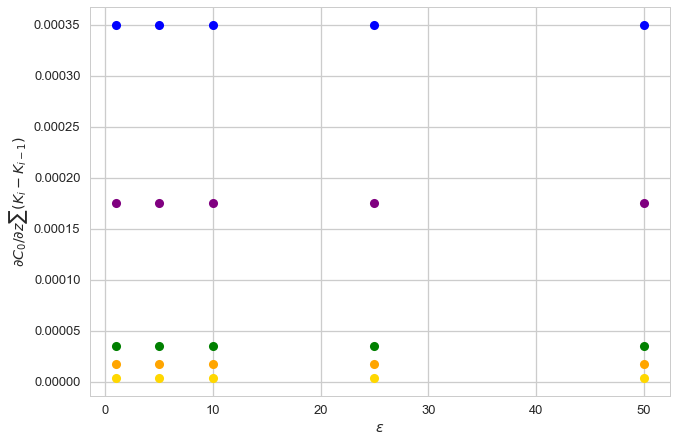

In [10]:
IC = np.ones(nz)
for ii in range(nz):
    IC[ii]=0.035*ii*dz+7.9

dCdz = np.mean((IC[1:]-IC[:-1])/dz)
print(dCdz)
colors =['blue', 'purple', 'green', 'orange', 'gold', 'magenta']

for kappa_canyon, col in zip([1E-2, 5E-3, 1E-3, 5E-4, 1E-4],colors):
    for eps in [1,5,10,25,50]:
        KK = smoothHS(nz, int(nz/2), eps, dz, kappa_bg, kappa_canyon)
        plt.plot(eps, dCdz*np.sum(KK[1:]-KK[:-1]), 'o', color = col)
        print(dCdz*np.sum(KK[1:]-KK[:-1]))
   

plt.xlabel(r'$\epsilon$')
plt.ylabel(r'$\partial C_0/\partial z \sum(K_i-K_{i-1})$')

0.00035
0.00035
0.00035
0.00035
0.00035
0.000175
0.000175
0.000175
0.000175
0.000175
3.5e-05
3.5e-05
3.5e-05
3.5e-05
3.5e-05
1.75e-05
1.75e-05
1.75e-05
1.75e-05
1.75e-05
3.5e-06
3.5e-06
3.5e-06
3.5e-06
3.5e-06


Text(0.5,1,'L')

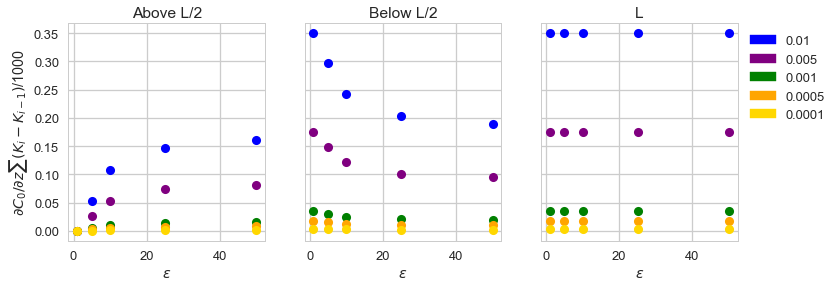

In [11]:
fig, ax = plt.subplots(1,3, figsize=(12,4), sharey=True)
patches = []
for kappa_canyon, col in zip([1E-2, 5E-3, 1E-3, 5E-4, 1E-4],colors):
    for eps in [1,5,10,25,50]:
        KK = smoothHS(nz, int(nz/2), eps, dz, kappa_bg, kappa_canyon)
        ax[0].plot(eps, dCdz*np.sum(KK[1:int(L/(2*dz))]-KK[:int(L/(2*dz))-1])*1000, 'o', color = col)
        ax[1].plot(eps, dCdz*np.sum(KK[int(L/(2*dz)):]-KK[int(L/(2*dz))-1:-1])*1000, 'o', color = col)
        ax[2].plot(eps, dCdz*np.sum(KK[1:]-KK[:-1])*1000, 'o', color = col, label = '$K_{can}$')
        
        print(dCdz*np.sum(KK[1:]-KK[:-1]))
    m_patch = mpatches.Patch(color=col,label=str(kappa_canyon))
    patches.append(m_patch)
    
ax[0].set_xlabel(r'$\epsilon$')
ax[1].set_xlabel(r'$\epsilon$')
ax[2].set_xlabel(r'$\epsilon$')
ax[0].set_ylabel(r'$\partial C_0/\partial z \sum(K_i-K_{i-1})$/1000')

ax[2].legend(handles=patches,bbox_to_anchor=(1,1))

ax[0].set_title(r'Above L/2')
ax[1].set_title(r'Below L/2')
ax[2].set_title(r'L')

0.00035
0.00035
0.00035
0.00035
0.00035
0.000175
0.000175
0.000175
0.000175
0.000175
3.5e-05
3.5e-05
3.5e-05
3.5e-05
3.5e-05
1.75e-05
1.75e-05
1.75e-05
1.75e-05
1.75e-05
3.5e-06
3.5e-06
3.5e-06
3.5e-06
3.5e-06


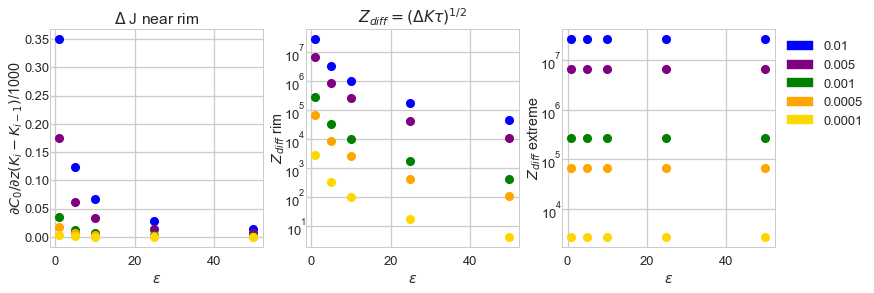

In [28]:
fig, ax = plt.subplots(1,3, figsize=(13,4))
patches = []
for kappa_canyon, col in zip([1E-2, 5E-3, 1E-3, 5E-4, 1E-4],colors):
    for eps in [1,5,10,25,50]:
        KK = smoothHS(nz, int(nz/2), eps, dz, kappa_bg, kappa_canyon)
        ax[0].plot(eps, dCdz*(KK[int(L/(2*dz))+1]-KK[int(L/(2*dz))-1])*1000, 'o', color = col)
        ax[1].plot(eps, ((KK[int(L/(2*dz))-1]-KK[int(L/(2*dz))+1])*6*3600*24)**2, 'o', color = col)
        ax[2].plot(eps, ((KK[int((L/2-eps)/dz)]-KK[int((L/2+eps)/dz)])*6*3600*24)**2, 'o', color = col, label = '$K_{can}$')
        
        print(dCdz*np.sum(KK[1:]-KK[:-1]))
    m_patch = mpatches.Patch(color=col,label=str(kappa_canyon))
    patches.append(m_patch)
    
ax[0].set_xlabel(r'$\epsilon$')
ax[1].set_xlabel(r'$\epsilon$')
ax[2].set_xlabel(r'$\epsilon$')
ax[0].set_ylabel(r'$\partial C_0/\partial z (K_i-K_{i-1})$/1000', labelpad=0)
ax[1].set_ylabel(r'$Z_{diff}$ rim', labelpad=-3)
ax[2].set_ylabel(r'$Z_{diff}$ extreme', labelpad=-3)

ax[2].legend(handles=patches,bbox_to_anchor=(1,1))

ax[0].set_title(r'$\Delta$ J near rim')
ax[1].set_title(r'$Z_{diff}=(\Delta K \tau)^{1/2}$')
ax[1].set_yscale("log", nonposy='clip')
ax[2].set_yscale("log", nonposy='clip')
ax[0].tick_params(axis='y', pad=0)
ax[1].tick_params(axis='y', pad=0)
ax[2].tick_params(axis='y', pad=0)
